In [1]:
# !gcc --version
# !g++ --version
# !ninja --version

In [2]:
# !pip install torch

In [3]:
# %pip install --no-build-isolation git+https://github.com/facebookresearch/detectron2.git

In [4]:
# Импорты
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# Устанавливаем логгер для детектрона
import detectron2

# Для печати логов
from detectron2.utils.logger import setup_logger

# Инициализируем логгер
setup_logger()

# Зоопарк моделей (по аналогии с torchvision.models)
from detectron2 import model_zoo

# Отдельный класс для предикта разными моделями
from detectron2.engine import DefaultPredictor

# Всея конфиг: все будем делать через него
from detectron2.config import get_cfg

# Для визуализации
from detectron2.utils.visualizer import Visualizer

# Для собственного датасета
from detectron2.data import MetadataCatalog, DatasetCatalog

import torch
import torch.nn.functional as F

from detectron2.structures import Boxes

/home/dmitry/elbrus/Phase2/ds-phase-2-git/week2/.venv/lib/python3.12/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


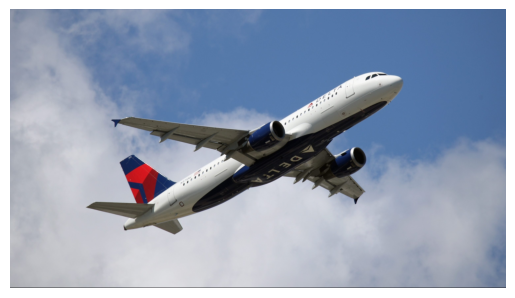

In [5]:
# Загружаем картинку и распечатываем
# !wget https://www.nxsttv.com/nmw/wp-content/uploads/sites/107/2021/06/DeltaPlaneGettyImages-1170328686-e1623504953879.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)  # BlueGreenRed -> RedGreenBlue (=torch.permute)
plt.axis("off")
plt.show()

In [6]:
# Используем дефолтный конфиг
cfg = get_cfg()

# Репозиторий: https://github.com/facebookresearch/detectron2/tree/main

# Пути к моделям
det_model = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"
seg_model = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

# Загружаем конфиг для модели MASK RCNN R 50
# COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file(seg_model))

# Устанавливаем порог для детекции: если уровень
# доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# Загружаем веса модели модель
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(seg_model)
# Создаем объект предиктора – он универсальный для моделей
predictor = DefaultPredictor(cfg)

# Передаем в объект загруженное выше изображение
outputs = predictor(im)

[09/17 17:50:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...


/home/dmitry/elbrus/Phase2/ds-phase-2-git/week2/.venv/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


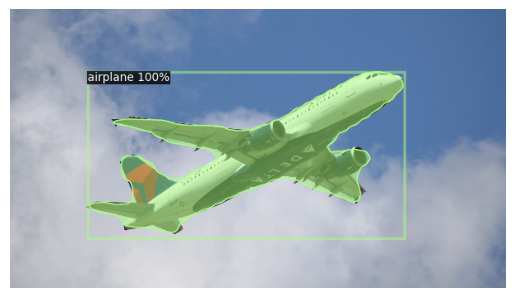

In [7]:
# Визуализируем
instances = outputs["instances"].to("cpu")

# Получаем исходные размеры
h_orig, w_orig = im_rgb.shape[:2]
h_pred, w_pred = instances.image_size  # размер, на котором модель делала предсказание

scale_y = h_orig / h_pred
scale_x = w_orig / w_pred

# 1. Рескейлим боксы
boxes = instances.pred_boxes.tensor
boxes = boxes * torch.tensor([scale_x, scale_y, scale_x, scale_y])
instances.pred_boxes = Boxes(boxes)

# 2. Рескейлим маски, если они есть
if instances.has("pred_masks"):
    masks = instances.pred_masks.unsqueeze(1).float()  # (N,1,H,W)
    masks = F.interpolate(
        masks, size=(h_orig, w_orig), mode="bilinear", align_corners=False
    )
    instances.pred_masks = masks[:, 0].bool()
v = Visualizer(
    im_rgb,  # меняем каналы местами. (как torch.permute)
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
    scale=0.2,  # масшатаб картинки
)

out = v.draw_instance_predictions(instances)

img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
# plt.imshow(img)
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

In [8]:
from roboflow import Roboflow

In [10]:
rf = Roboflow(api_key="PN6wLUL75bQSI1gmZcAE")
project = rf.workspace("elbrus-soa0u").project("heroes-3-objects-on-map-dfdcg")
version = project.version(4)
dataset = version.download("coco-segmentation", location="dataset/", overwrite=True)
print("DATASET LOCATION:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dataset/ in coco-segmentation:: 100%|██████████| 171/171 [00:00<00:00, 4306.11it/s]

DATASET LOCATION: /home/dmitry/elbrus/Phase2/ds-phase-2-git/week2/day3_detectron/dataset


In [11]:
!ls -lah dataset/
!find dataset/ -maxdepth 2 -name "_annotations.coco.json"

total 40K
drwxrwxr-x 4 dmitry dmitry 4.0K Sep 17 17:53 .
drwxrwxr-x 7 dmitry dmitry 4.0K Sep 17 16:53 ..
-rw-rw-r-- 1 dmitry dmitry  153 Sep 17 17:53 README.dataset.txt
-rw-rw-r-- 1 dmitry dmitry 1.3K Sep 17 17:53 README.roboflow.txt
drwxrwxr-x 2 dmitry dmitry  20K Sep 17 16:32 train
drwxrwxr-x 2 dmitry dmitry 4.0K Sep 17 16:32 valid
dataset/valid/_annotations.coco.json
dataset/train/_annotations.coco.json


In [12]:
from pathlib import Path
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

base = Path(dataset.location)

In [13]:
for split in ["train", "valid", "test"]:
    ann = base / split / "_annotations.coco.json"
    img = base / split
    if ann.is_file() and img.is_dir():
        register_coco_instances(f"map_objects_{split}", {}, str(ann), str(img))
        print(f"✔ зарегистрирован: map_objects_{split}")
    else:
        print(f"⚠ пропущен: {split}")

✔ зарегистрирован: map_objects_train
✔ зарегистрирован: map_objects_valid
⚠ пропущен: test


In [44]:
map_objects_train_meta = MetadataCatalog.get("map_objects_train")
map_objects_train_data = DatasetCatalog.get("map_objects_train")
map_objects_valid_meta = MetadataCatalog.get("map_objects_valid")
map_objects_valid_data = DatasetCatalog.get("map_objects_valid")

print("Классы:", map_objects_train_meta.thing_classes)
print("Mapping:", map_objects_train_meta.thing_dataset_id_to_contiguous_id)

WARNING [09/17 18:29:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/17 18:29:36 d2.data.datasets.coco]: Loaded 150 images in COCO format from /home/dmitry/elbrus/Phase2/ds-phase-2-git/week2/day3_detectron/dataset/train/_annotations.coco.json
WARNING [09/17 18:29:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/17 18:29:36 d2.data.datasets.coco]: Loaded 15 images in COCO format from /home/dmitry/elbrus/Phase2/ds-phase-2-git/week2/day3_detectron/dataset/valid/_annotations.coco.json
Классы: ['Heroes-3-objects-on-map', 'Hero', 'Mine', 'Town']
Mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [38]:
### Обучение модели
import os, cv2, random
import torch
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

yaml_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(yaml_path))
cfg.DATASETS.TRAIN = ("map_objects_train",)
cfg.DATASETS.TEST = ("map_objects_valid",)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yaml_path)
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(map_objects_train_meta.thing_classes)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [31]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/17 18:00:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (5, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (16, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[09/17 18:00:37 d2.engine.train_loop]: Starting training from iteration 0
[09/17 18:00:43 d2.utils.events]:  eta: 0:09:37  iter: 19  total_loss: 3.161  loss_cls: 1.528  loss_box_reg: 0.7759  loss_mask: 0.6912  loss_rpn_cls: 0.129  loss_rpn_loc: 0.02404    time: 0.2831  last_time: 0.2724  data_time: 0.0127  last_data_time: 0.0042   lr: 4.9952e-05  max_mem: 3954M
[09/17 18:00:49 d2.utils.events]:  eta: 0:09:32  iter: 39  total_loss: 2.587  loss_cls: 0.9723  loss_box_reg: 0.7686  loss_mask: 0.6812  loss_rpn_cls: 0.114  loss_rpn_loc: 0.02351    time: 0.2866  last_time: 0.2933  data_time: 0.0040  last_data_time: 0.0036   lr: 9.9902e-05  max_mem: 3954M
[09/17 18:00:54 d2.utils.events]:  eta: 0:09:08  iter: 59  total_loss: 2.394  loss_cls: 0.7836  loss_box_reg: 0.8497  loss_mask: 0.6566  loss_rpn_cls: 0.08767  loss_rpn_loc: 0.0193    time: 0.2826  last_time: 0.3269  data_time: 0.0041  last_data_time: 0.0047   lr: 0.00014985  max_mem: 3954M
[09/17 18:01:00 d2.utils.events]:  eta: 0:09:01  iter

[09/17 18:22:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


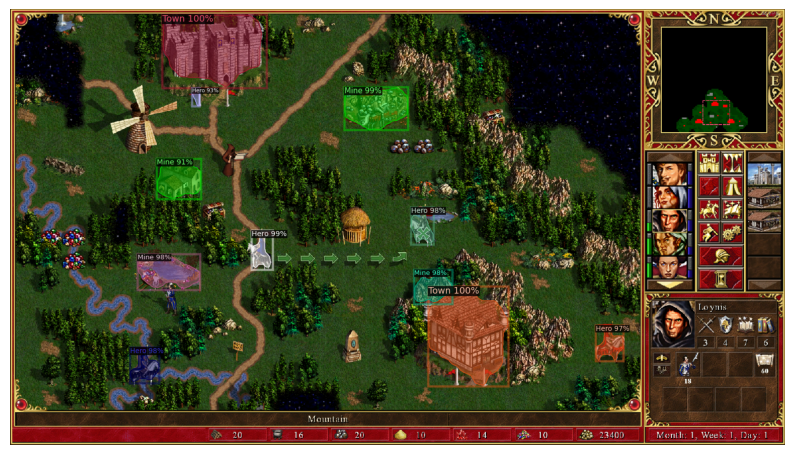

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
predictor = DefaultPredictor(cfg)

# Подставь путь к реальной картинке из test
# im = cv2.imread(str(base / "valid" / os.listdir(base / "valid")[7]))
im = cv2.imread("test_imgs/5.png")
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=map_objects_train_meta, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 10))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

In [ ]:
# with open("config_final.yaml", "w") as f:
#     f.write(cfg.dump())

In [ ]:
# print(cfg.MODEL.ROI_HEADS.CLASSES)

AttributeError: CLASSES

In [ ]:
# !rm gradio.pyc
# !rm -rf __pycache__/

rm: cannot remove 'gradio.pyc': No such file or directory


In [45]:
torch.cuda.empty_cache()